## POS tagging using modified Viterbi

### Data Preparation

In [ ]:
#Importing libraries
import nltk

In [ ]:
import random
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import time

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# reading the Treebank tagged sentences
nltk.download('universal_tagset')
nltk.download('treebank')
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [ ]:
print (nltk_data[:2])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]]


In [ ]:
# Splitting into train and test
random.seed(12321)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('*-1', 'X'), ('Taking', 'VERB'), ('a', 'DET'), ('cue', 'NOUN'), ('from', 'ADP'), ('California', 'NOUN'), (',', '.'), ('more', 'ADJ'), ('politicians', 'NOUN'), ('will', 'VERB'), ('launch', 'VERB'), ('their', 'PRON'), ('campaigns', 'NOUN'), ('by', 'ADP'), ('*-1', 'X'), ('backing', 'VERB'), ('initiatives', 'NOUN'), (',', '.'), ('says', 'VERB'), ('0', 'X'), ('*T*-2', 'X'), ('David', 'NOUN'), ('Magleby', 'NOUN'), ('of', 'ADP'), ('Brigham', 'NOUN'), ('Young', 'NOUN'), ('University', 'NOUN'), ('.', '.')], [('Attorneys', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('third', 'ADJ'), ('stock-manipulation', 'ADJ'), ('trial', 'NOUN'), ('of', 'ADP'), ('GAF', 'NOUN'), ('Corp.', 'NOUN'), ('began', 'VERB'), ('opening', 'VERB'), ('arguments', 'NOUN'), ('yesterday', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('Manhattan', 'NOUN'), ('courtroom', 'NOUN'), ('of', 'ADP'), ('U.S.', 'NOUN'), ('District', 'NOUN'), ('Judge', 'NOUN'), ('Mary', 'NOUN'), ('Johnson', 'NOUN'), ('Lowe', 'NOUN'), ('.', '.')], [('

In [ ]:
test_set_base = [tup for sent in test_set for tup in sent]
test_set_base[:15]

[('Your', 'PRON'),
 ('Oct.', 'NOUN'),
 ('6', 'NUM'),
 ('editorial', 'NOUN'),
 ('``', '.'),
 ('The', 'NOUN'),
 ('Ill', 'NOUN'),
 ('Homeless', 'NOUN'),
 ("''", '.'),
 ('referred', 'VERB'),
 ('to', 'PRT'),
 ('research', 'NOUN'),
 ('by', 'ADP'),
 ('us', 'PRON'),
 ('and', 'CONJ')]

In [ ]:
test_set_tagged_words = [tup[0] for sent in test_set for tup in sent]
test_set_tagged_words[:15]

['Your',
 'Oct.',
 '6',
 'editorial',
 '``',
 'The',
 'Ill',
 'Homeless',
 "''",
 'referred',
 'to',
 'research',
 'by',
 'us',
 'and']

In [ ]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95634

In [ ]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['*-1',
 'Taking',
 'a',
 'cue',
 'from',
 'California',
 ',',
 'more',
 'politicians',
 'will']

In [ ]:
# vocabulary
V = set(tokens)
print(len(V))

12075


In [ ]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [ ]:
print(T)

{'ADJ', 'NUM', 'VERB', 'CONJ', 'ADV', 'DET', 'PRON', 'PRT', 'X', '.', 'NOUN', 'ADP'}


In [ ]:
print ('Pronouns')
print (set([pair[0].lower() for pair in train_tagged_words if pair[1]=='PRON']))

print ('ADP')
print (set([pair[0].lower() for pair in train_tagged_words if pair[1]=='ADP']))

print ('PRT')
print (set([pair[0].lower() for pair in train_tagged_words if pair[1]=='PRT']))

print ('CONJ')
print (set([pair[0].lower() for pair in train_tagged_words if pair[1]=='CONJ']))

print ('.')
print (set([pair[0].lower() for pair in train_tagged_words if pair[1]=='.']))

Pronouns
{'themselves', 'him', 'his', 'you', 'i', 'us', 'her', 'whose', 'my', 'its', 'they', 'himself', 'one', 'he', 'yourself', 'herself', 'she', 'itself', 'me', 'them', 'we', 'whom', 'your', 'their', 'what', 'it', 'our', 'who'}
ADP
{'except', 'complicated', 'if', 'despite', 'up', 'that', 'unless', 'vs.', 'next', 'till', 'between', 'beyond', 'since', 'whereas', 'among', 'of', 'near', 'under', 'until', 'far', 'against', 'over', 'by', 'during', 'out', 'for', 'via', 'per', 'de', 'into', 'unlike', '@', 'outside', 'in', 'whether', 'toward', 'notwithstanding', 'once', 'to', 'a', 'with', 'off', 'worth', 'while', 'throughout', 'above', 'because', 'amid', 'along', 'through', 'across', 'on', 'about', 'down', 'onto', 'although', 'upon', 'but', 'like', 'below', 'which', 'after', 'and', 'so', 'within', 'though', 'than', 'around', 'aboard', 'from', 'ago', 'before', 'without', 'behind', 'at', 'as', 'besides'}
PRT
{'to', 'over', 'together', 'off', 'by', 'up', 'out', 'around', 'away', 'across', 'in', 

In [ ]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [ ]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [ ]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [ ]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [ ]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [ ]:
tags_df.loc['.', :]

ADJ     0.044520
NUM     0.082309
VERB    0.088951
CONJ    0.057984
ADV     0.052329
DET     0.174311
PRON    0.064806
PRT     0.002423
X       0.026838
.       0.092362
NOUN    0.221255
ADP     0.091823
Name: ., dtype: float32

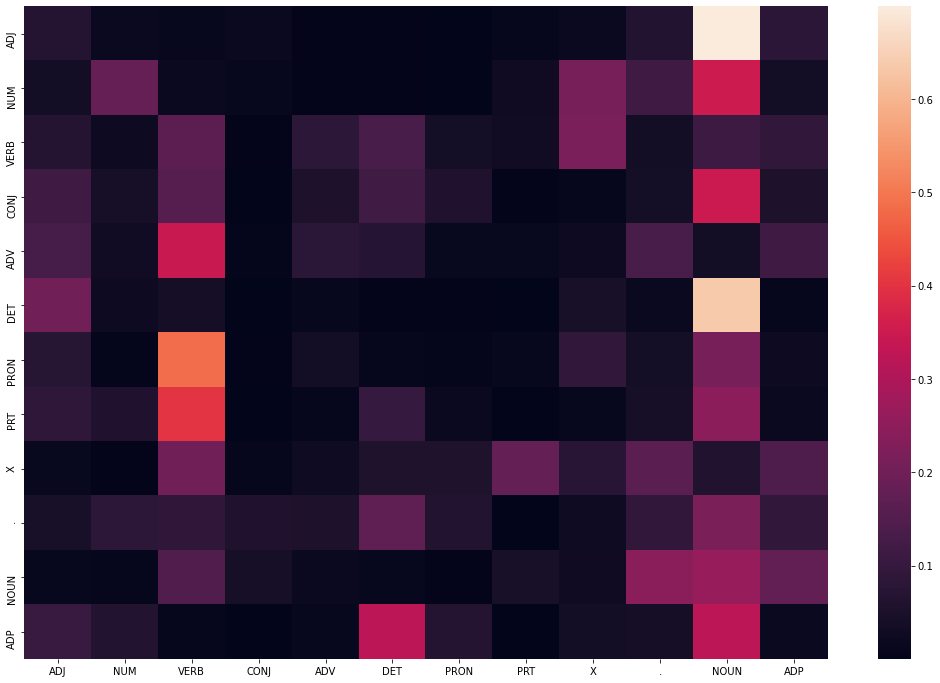

In [ ]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


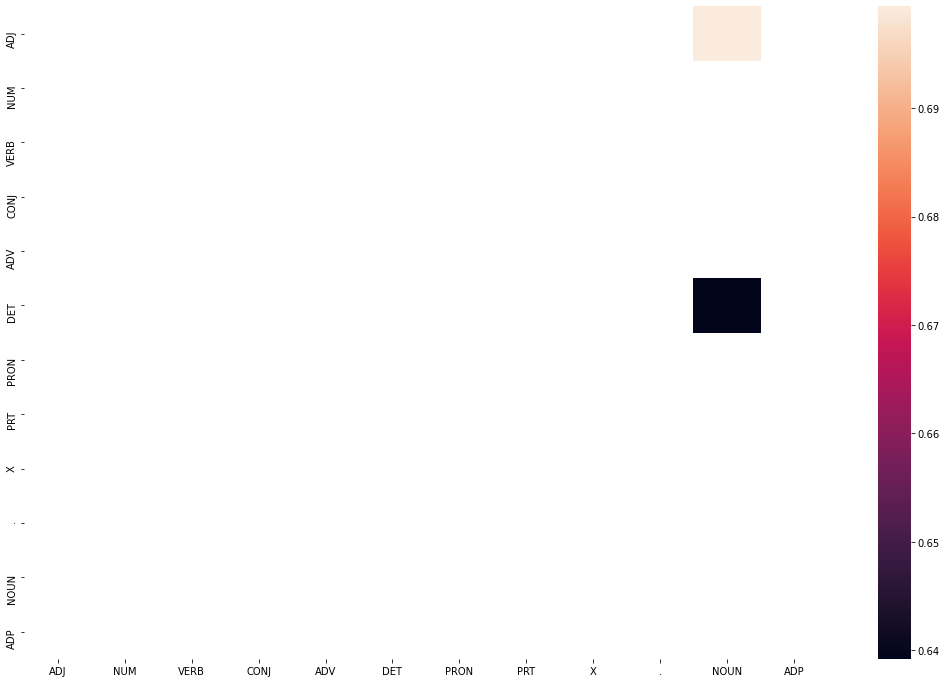

In [ ]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [ ]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(42)

# choose random 15 sents
rndom = [random.randint(1,len(test_set)) for x in range(15)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

In [ ]:
accuracy_table = pd.DataFrame(columns = ['Logic Name', 'Time to execute', 'Accuracy'])

The Viterbi Heuristic function will fail to predict the tag of the unknown word.

In order to get over it, I have chosen three algorithms
- **Consider Transition**: When a word is not present in the training set, then the emission probability of it will be zero. As it gets multiplied with the transition probability for the calculation of the state probability, the state probability will also be zero. Hence, in such cases I will consider only the transition probability.

- **Max occurences**: A tag which occurs the highest number of times is most probably the tag of the unknown word. It will not hurt the accuracy but can increase it for sure!

- **Regular Expression (rule based tagger)**: I have designed a regex based tagger which can predict the tag based upon English language syntax.

In [ ]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words, algo_type='vanilla'):       
    from collections import Counter
    patterns = [
        (r'.*ly$', 'ADV'),
        (r'^(0|([*|-|$].*))','X'), # Any special character combination
        (r'.*ould$', 'X'), # modals
        (r'(The|the|A|a|An|an|that|That)$', 'DET'),
        (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
        (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
        (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
        (r'[0-9].?[,\/]?[0-9]*','NUM'),# Numbers 
        (r'(their|we|he|his|its|us|her|my|them|whom|i|one|she|they|whose|me|you|who|him|it)$', 'PRON'),
        (r'.*elf$', 'PRON'), 
        (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
        (r'.*ness$', 'NOUN'),
        (r'.*\'s$', 'NOUN'),              # possessive nouns
        (r'.*s$', 'NOUN'),                # plural nouns
        (r'.*', 'NOUN')    
      ]
    rule_based_tagger = nltk.RegexpTagger(patterns)
    
    most_common_tag = Counter([pair[1] for pair in train_tagged_words]).most_common()[0][0]
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    word_bag = list(set([pair[0] for pair in train_bag]))
    skipped = False
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        word_present = word in word_bag
        for tag in T:
            state_probability=0
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            presence, total_count =  word_given_tag(words[key], tag)
            emission_p = presence / total_count
            if not word_present:
                if algo_type == 'vanilla':
                    state_probability = emission_p * transition_p    
                elif algo_type == 'consider_transition':
                    state_probability = transition_p    
                elif algo_type == 'max_occur':
                    if tag == most_common_tag:
                        state_probability=1
                elif algo_type == 'regex':
                    if tag == rule_based_tagger.tag([word])[0][1]:
                        state_probability=1
            else:
                state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [ ]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_set_tagged_words, algo_type='vanilla')
end = time.time()
difference = end-start

# accuracy
check = [i for i, j in zip(tagged_seq, test_set_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
accuracy_table.loc[0] = ['Vanilla Viterbi', str(round(difference, 2)), str(round(accuracy*100, 2))]
base_tagged_seq = tagged_seq

### Solve the problem of unknown words

In [ ]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_set_tagged_words, algo_type='consider_transition')
end = time.time()
difference = end-start

# accuracy
check = [i for i, j in zip(tagged_seq, test_set_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
accuracy_table.loc[1] = ['Consider Transition', str(round(difference, 2)), str(round(accuracy*100, 2))]

In [ ]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_set_tagged_words, algo_type='most_occur')
end = time.time()
difference = end-start

# accuracy
check = [i for i, j in zip(tagged_seq, test_set_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
accuracy = len(check)/len(tagged_seq)
accuracy_table.loc[2] = ['Max Occuring Tag', str(round(difference, 2)), str(round(accuracy*100, 2))]

In [ ]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_set_tagged_words, algo_type='regex')
end = time.time()
difference = end-start

# accuracy
check = [i for i, j in zip(tagged_seq, test_set_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
accuracy_table.loc[3] = ['Regular Expression', str(round(difference, 2)), str(round(accuracy*100, 2))]

#### Evaluating tagging accuracy

In [55]:
accuracy_table

,Logic Name,Time to execute,Accuracy
0,Vanilla Viterbi,539.09,91.25
1,Consider Transition,533.16,93.38
2,Max Occuring Tag,522.88,91.25
3,Regular Expression,521.69,95.12


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

As can be seen in the *accuracy_table*, the Regular Expression rule based tagger is the most accurate one with 95.12% accuracy.

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [67]:
# The tagged cases in vanilla were saved in base_tagged_seq and for the rule based tagger are in tagged_seq

# The incorrect one in the vanilla are:

vanilla_incorrect = list(set([j[0] for i, j in enumerate(zip(base_tagged_seq, test_set_base)) if j[0]!=j[1]]))
regex_incorrect   = list(set([j[0] for i, j in enumerate(zip(tagged_seq, test_set_base)) if j[0]!=j[1]]))


In [68]:
print (len(vanilla_incorrect), vanilla_incorrect[:2])

392 [('binders', 'ADJ'), ('Perignon', 'ADJ')]


In [69]:
print (len(regex_incorrect), regex_incorrect[:2])

204 [('impudent', 'NOUN'), ('care', 'VERB')]


---
The following list are the words/tags which were incorrect in the vanilla parser and were corrected in the most accurate parser (regex rule based parser)

In [71]:
list(set(vanilla_incorrect) - set(regex_incorrect))

[('binders', 'ADJ'),
 ('8.56', 'ADJ'),
 ('Perignon', 'ADJ'),
 ('1614', 'ADJ'),
 ('embroiled', 'ADJ'),
 ('indifference', 'ADJ'),
 ('helm', 'ADJ'),
 ('Kensington', 'ADJ'),
 ('*T*-125', 'ADJ'),
 ('monster', 'ADJ'),
 ('transcribe', 'ADJ'),
 ('excessively', 'ADJ'),
 ('brakes', 'ADJ'),
 ('UPHELD', 'ADJ'),
 ('castle', 'ADJ'),
 ('Terrence', 'ADJ'),
 ('hosted', 'ADJ'),
 ('personnel', 'ADJ'),
 ('Sutcliffe', 'ADJ'),
 ('Ark', 'ADJ'),
 ('R.I.', 'ADJ'),
 ('warming', 'ADJ'),
 ('Claude', 'ADJ'),
 ('501', 'ADJ'),
 ('gallium', 'ADJ'),
 ('threatens', 'ADJ'),
 ('deprived', 'ADJ'),
 ('1990-91', 'ADJ'),
 ('averted', 'ADJ'),
 ('working', 'NOUN'),
 ('protected', 'ADJ'),
 ('*T*-220', 'ADJ'),
 ('Women', 'ADJ'),
 ('rarefied', 'ADJ'),
 ('pine', 'ADJ'),
 ('handed', 'ADJ'),
 ('Graham', 'ADJ'),
 ('dinosaurs', 'ADJ'),
 ('Rey\\/Fawcett', 'ADJ'),
 ('secret', 'ADJ'),
 ('Kingsbridge', 'ADJ'),
 ('expenditures', 'ADJ'),
 ('families', 'ADJ'),
 ('58.64', 'ADJ'),
 ('tea', 'ADJ'),
 ('*-137', 'ADJ'),
 ('Fellowship', 'ADJ'),
 ('